In [32]:
from glob import glob
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import csv
from tqdm import tqdm

### Generate Embeddings from Flickr8k Dataset

#### Create image embeddings for all images

In [3]:
# Load a pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)
# Remove the classification layer (the final fully connected layer)
encoder = nn.Sequential(*list(resnet18.children())[:-1])

# Define a transformation to preprocess the images
data_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

c:\Users\thaou\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\thaou\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
dataset_folder = 'DATASET-Flickr8k/Images'
embedding_folder = 'DATASET-Flickr8k-Img-Embeddings'

# Ensure the embedding folder exists
os.makedirs(embedding_folder, exist_ok=True)

# Create an empty list to store image embeddings
img_feature_list = []

# Count the number of files in the folder
num_files = len([f for f in os.listdir(dataset_folder) if os.path.isfile(os.path.join(dataset_folder, f))])

# Loop over each image in the dataset folder with a progress bar
for filename in tqdm(os.listdir(dataset_folder), total=num_files, desc="Processing Images"):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Construct the image path
        image_path = os.path.join(dataset_folder, filename)

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image = data_transform(image)

        # Encode the image
        with torch.no_grad():
            feature_vector = encoder(image.unsqueeze(0))

        # Flatten the tensor and convert to NumPy array
        flat_vector = feature_vector.view(-1).numpy()

        # Append the filename and feature vector tuple to the list
        img_feature_list.append((filename, *flat_vector))

Processing Images: 100%|██████████| 8091/8091 [12:07<00:00, 11.12it/s]


In [5]:
# Save the embeddings to a CSV file
csv_filename = os.path.join(embedding_folder, 'flickr8k_image_embeddings.csv')
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    header = ['Filename'] + [f'Feature_{i}' for i in range(len(flat_vector))]
    csv_writer.writerow(header)
    # Write data
    csv_writer.writerows(img_feature_list)

print(f"Embeddings saved to {csv_filename}")

Embeddings saved to DATASET-Flickr8kEmbeddings\flickr8k_image_embeddings.csv


#### Create text embeddings for all captions

In [11]:
# Initialize ChromaDB
client = chromadb.Client()
collection_name = "caption_embeddings"

# Delete the collection if it already exists to avoid errors
# client.delete_collection(collection_name)

# Create a new collection
collection = client.create_collection(collection_name)

# Folder containing Flickr8k Text Embeddings CSV files
folder_path = 'DATASET-Flickr8k-Img-Embeddings'

In [ ]:
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)

        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path, header=None)
        
        # Extract caption_id from the filename 
        caption_id = filename.split('_')[0]

        # Each row contains embedding vectors of a caption
        for index, row in df.iterrows():
            if len(row) > 0:
                embeddings_array = np.array(row.values).tolist()
                sentence_id = f"Sentence_{index}"

                # Add embeddings to the collection
                collection.add(embeddings=[embeddings_array],
                               ids=[f'{caption_id}-{sentence_id}'])

# Retrieve and print the contents of the collection
collection = client.get_collection(collection_name)
print(collection.get())

In [ ]:
# Save the collection
client = chromadb.PersistentClient(path="Chromadb-Collection")

### Load Flickr8K Dataset

Concatenate all embeddings into a single NumPy array

In [14]:
def process_csv_files(embedding_folder, has_header=True, skip_first_column=False):
    csv_files = glob(embedding_folder + '/*.csv')
    all_embeddings = []

    for csv_file in csv_files:
                                                                    # Read the CSV file
        embeddings_df = pd.read_csv(csv_file, header=0 if has_header else None)
        
        if skip_first_column:                                       # Skip the first column for video csv files
            embeddings_df = embeddings_df.iloc[:, 1:]               # because it contains the name of video frame

    
        embeddings_array = embeddings_df.astype(np.float64).values  # Convert all elements to numpy.float64
                                                                    # Remove rows with NaN values
        embeddings_array = embeddings_array[~np.isnan(embeddings_array).any(axis=1)]
        all_embeddings.append(embeddings_array)                     # Append the NumPy array to the list
        

    # Concatenate all embeddings into a single NumPy array
    embeddings_array = np.concatenate(all_embeddings, axis=0)

    return embeddings_array


In [15]:
img_embedding_folder = 'DATASET-Flickr8k-Img-Embeddings'
img_embeddings = process_csv_files(img_embedding_folder, has_header=True, skip_first_column=True)
print(img_embeddings)

[[0.90512055 0.99906915 0.9146847  ... 0.90225774 1.087199   1.0167476 ]
 [0.84700495 0.9211991  0.97732145 ... 0.83345467 0.9408302  0.98860836]
 [0.94614327 0.9429792  0.91534483 ... 0.89839077 1.0792063  0.9620709 ]
 ...
 [0.8720677  0.9208743  0.85512817 ... 0.91363573 1.0566888  1.0121216 ]
 [0.9431097  0.98371744 0.962219   ... 0.90475065 1.1498048  0.9818486 ]
 [0.89349157 0.8881252  0.9098636  ... 0.9203147  1.0604336  0.94605654]]


In [18]:
cap_embedding_folder = 'DATASET-Flickr8k-Txt-Embeddings'
cap_embeddings = process_csv_files(cap_embedding_folder, has_header=False)
print(cap_embeddings)

[[-0.10595703  0.21386719  0.11865234 ...  0.10693359  0.02368164
  -0.03540039]
 [ 0.18945312  0.13671875 -0.09472656 ...  0.07617188  0.01538086
  -0.05029297]
 [ 0.13867188  0.0037384   0.06445312 ... -0.08691406 -0.00897217
   0.03759766]
 ...
 [-0.10107422  0.02709961 -0.37304688 ...  0.16992188  0.14453125
   0.21484375]
 [-0.06884766  0.15917969  0.02905273 ... -0.36132812 -0.09130859
  -0.09570312]
 [ 0.06640625  0.328125    0.06787109 ... -0.515625   -0.25976562
   0.04492188]]


In [19]:
# Check data types in the video_embeddings array
print("Data Types in img_embeddings:", set(type(item) for row in img_embeddings for item in row))

Data Types in img_embeddings: {<class 'numpy.float64'>}


### Pre-processing

##### **Note:** 
Even though calling fit_transform separately for text and video embeddings because it could lead to normalization based on different statistics for each set, since the embedding dimensions are not initially equal the image embeddings needs to be processed separately.

In [30]:
# Normalize the text embeddings -----------------------------
scaler_text = StandardScaler()
txt_embeddings_normalized = scaler_text.fit_transform(cap_embeddings)
# Normalize the image embeddings --------------------------------
scaler_image = StandardScaler()
image_embeddings_normalized = scaler_image.fit_transform(img_embeddings)

# Ensure the same dimensionality ---------------------------------
# Find the minimum dimensionality between text and image embeddings
min_dim = min(txt_embeddings_normalized.shape[1], image_embeddings_normalized.shape[1])

# Trim both embeddings to the minimum dimensionality
text_embeddings_normalized = txt_embeddings_normalized[:, :min_dim]
image_embeddings_normalized = image_embeddings_normalized[:, :min_dim]

# Convert normalized NumPy array back to PyTorch tensor
image_embeddings_normalized_tensor = torch.tensor(image_embeddings_normalized, dtype=torch.float32)
text_embeddings_normalized_tensor = torch.tensor(txt_embeddings_normalized, dtype=torch.float32)


In [21]:
print("------------------------------------------------------------------------------")
print("This indicates that there are", len(cap_embeddings),"sentences and each frame is\nrepresented by a 512-dimensional embedding" )
print("text_embeddings.shape:             ",cap_embeddings.shape)
print("text_embeddings_normalized.shape:  ",text_embeddings_normalized.shape)
print("text_embeddings_normalized_tensor: ",text_embeddings_normalized_tensor.shape)
print("------------------------------------------------------------------------------")
print("This indicates that there are 8091 images and each frame is\nrepresented by a 512-dimensional embedding" )
print("video_embeddings.shape:             ",img_embeddings.shape)
print("video_embeddings_reshaped.shape:    ",image_embeddings_normalized.shape)
print("video_embeddings_normalized_tensor: ",image_embeddings_normalized_tensor.shape)
print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
This indicates that there are 73377 sentences and each frame is
represented by a 512-dimensional embedding
text_embeddings.shape:              (73377, 300)
text_embeddings_normalized.shape:   (73377, 300)
text_embeddings_normalized_tensor:  torch.Size([73377, 300])
------------------------------------------------------------------------------
This indicates that there are 8091 images and each frame is
represented by a 512-dimensional embedding
video_embeddings.shape:              (8091, 512)
video_embeddings_reshaped.shape:     (8091, 300)
video_embeddings_normalized_tensor:  torch.Size([8091, 300])
------------------------------------------------------------------------------


##### **Check if dimensions of subtitle embeddings match the dimensions of video embeddings**

In [22]:
text_embeddings_normalized_tensor.shape[1] == image_embeddings_normalized_tensor.shape[1] 

True

### Text and Vision Encoder

In [31]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, projection_dim, num_layers=2, dropout_rate=0.1):
        super(ProjectionHead, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, projection_dim))
        for _ in range(num_layers):
            layers.extend([nn.ReLU(), nn.Linear(projection_dim, projection_dim), nn.Dropout(dropout_rate)])
        self.projection = nn.Sequential(*layers)

    def forward(self, x):
        return self.projection(x)

class VisionEncoder(nn.Module):
    def __init__(self, input_channels, projection_dim):
        super(VisionEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_channels, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, projection_dim),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

class TextEncoder(nn.Module):
    def __init__(self, input_dim, projection_dim):
        super(TextEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, projection_dim),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

### Create PyTorch Dataset of Text and Video Embeddings

In [24]:
class EmbeddingsDataset(Dataset):
    def __init__(self, video_embeddings, text_embeddings):
        self.video_embeddings = video_embeddings
        self.text_embeddings = text_embeddings

    def __len__(self):
        return len(self.video_embeddings)

    def __getitem__(self, idx):
        video_embedding = self.video_embeddings[idx]
        text_embedding = self.text_embeddings[idx]

        return {'video_embedding': video_embedding, 'text_embedding': text_embedding}


### PyTorch implementation of the dual encoder

In [25]:
class DualEncoder(nn.Module):
    def __init__(self, text_encoder, vision_encoder, temperature=1.0):
        super(DualEncoder, self).__init__()
        self.text_encoder = text_encoder
        self.vision_encoder = vision_encoder
        self.temperature = temperature
        self.loss_criterion = nn.CrossEntropyLoss()

    def forward(self, captions, images):
        # Get the embeddings
        caption_embeddings = self.text_encoder(captions)
        image_embeddings = self.vision_encoder(images)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # Calculate dot-product similarity for captions and images.
        logits = torch.matmul(caption_embeddings, image_embeddings.t()) / self.temperature
        captions_similarity = torch.matmul(caption_embeddings, caption_embeddings.t())
        images_similarity = torch.matmul(image_embeddings, image_embeddings.t())
        # Targets: average of similarities between captions and images.
        targets = torch.nn.functional.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature), dim=1
        )
        # Compute the loss using crossentropy.
        captions_loss = self.loss_criterion(logits, torch.argmax(targets, dim=1))
        images_loss = self.loss_criterion(logits.t(), torch.argmax(targets, dim=0))
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def training_step(self, captions, images):
        # Forward pass
        caption_embeddings, image_embeddings = self(captions, images)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        return loss

    def validation_step(self, captions, images):
        caption_embeddings, image_embeddings = self(captions, images)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        return loss


### Train the model
#### 1. Create Vision and Text Encoders
These encoders are responsible for transforming the input data (video frames and text) into a shared embedding space.
#### 2. Create DataLoader
Prepare data to iterate over batches of paired video and text embeddings. Each batch should contain corresponding video and text embeddings that you want to train on
#### 3. Instantiate Dual Encoder
This model takes the output embeddings from the VisionEncoder and TextEncoder and computes the loss based on the similarity between the embeddings.
#### 4. Training Loop
Iterates through DataLoader batches and train the Dual Encoder. In each iteration, video and text embeddings are passed through the VisionEncoder and TextEncoder, respectively. Then, these embeddings are fed to the Dual Encoder and compute the loss. Finally, backpropagate the gradients and update the model parameters.

Graph to visualize loss over epochs between training and validation set

In [26]:
from torch.utils.data.dataset import random_split

In [27]:
video_embeddings_normalized_tensor = torch.rand((1000, 300))
text_embeddings_normalized_tensor = torch.rand((1000, 300))

# Split the dataset into training and validation sets
total_samples = len(video_embeddings_normalized_tensor)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_dataset, val_dataset = random_split(
    EmbeddingsDataset(video_embeddings_normalized_tensor, text_embeddings_normalized_tensor),
    [train_size, val_size]
)

# DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Instantiate VisionEncoder, TextEncoder
vision_encoder = VisionEncoder(input_channels=300, projection_dim=512)
text_encoder = TextEncoder(input_dim=300, projection_dim=512)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=1.0)


Save the model as ***final_trained_model.pth***

In [28]:
# Training loop
optimizer = torch.optim.Adam(dual_encoder.parameters(), lr=0.001)
num_epochs = 10

# Lists to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_train_losses = []
    epoch_val_losses = []

    # Training
    dual_encoder.train()
    for batch in train_dataloader:
        captions, images = batch['text_embedding'], batch['video_embedding']
        optimizer.zero_grad()
        caption_embeddings, image_embeddings = dual_encoder(captions, images)
        loss = dual_encoder.compute_loss(caption_embeddings, image_embeddings)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    # Validation
    dual_encoder.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            captions, images = batch['text_embedding'], batch['video_embedding']
            caption_embeddings, image_embeddings = dual_encoder(captions, images)
            loss = dual_encoder.compute_loss(caption_embeddings, image_embeddings)
            epoch_val_losses.append(loss.item())

    # Calculate and store the average loss for the epoch
    avg_epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    avg_epoch_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    train_losses.append(avg_epoch_train_loss)
    val_losses.append(avg_epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss}, Val Loss: {avg_epoch_val_loss}")

    # Save the model after each epoch
    torch.save(dual_encoder.state_dict(), f'model_epoch_{epoch+1}.pth')

# Save the final trained model
torch.save(dual_encoder.state_dict(), 'final_trained_model.pth')


Epoch [1/10], Train Loss: 3.4082640075683592, Val Loss: 3.099536180496216
Epoch [2/10], Train Loss: 3.125346989631653, Val Loss: 3.3172830513545444
Epoch [3/10], Train Loss: 3.339826250076294, Val Loss: 2.5473721538271223
Epoch [4/10], Train Loss: 2.6017779302597046, Val Loss: 2.2739738055637906
Epoch [5/10], Train Loss: 2.1092772102355957, Val Loss: 2.2369749205453053
Epoch [6/10], Train Loss: 1.9658233785629273, Val Loss: 2.3282233646937778
Epoch [7/10], Train Loss: 1.6614169597625732, Val Loss: 2.5136687585285733
Epoch [8/10], Train Loss: 1.4856292724609375, Val Loss: 2.1954744032451083
Epoch [9/10], Train Loss: 2.29549298286438, Val Loss: 2.7917756182806834
Epoch [10/10], Train Loss: 2.191897692680359, Val Loss: 2.183121885572161


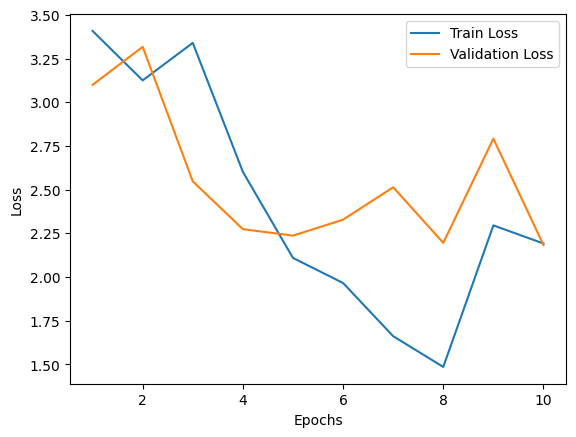

In [29]:
# Plot the loss graph
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()